This file is part of a program that is used to develop an objective way to
segment the fetus from ultrasound images, and to analyse the effectiveness of 
using the resulting mask to produce an unobstructed visualisation of the fetus.
The research is organised in three phases: (1) noise reduction filters, 
(2a) heuristic segmentation models, (2b) deep learning segmentation
approach (U-net), and (3) the volume visualisation. The program is developed
for the master Computational Science at the UvA from February to November 2020.

This file contains code for the noise reduction filters. <br>
You can run this file to plot the results of the noise reduction filter experiment.

Made by Romy Meester

In [1]:
"""
Phase 1: The noise reduction filters.
"""

import os
import numpy as np
import math
import time
from tqdm import tqdm
import SimpleITK as sitk
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

from skimage.metrics import structural_similarity as calc_ssim

In [2]:
jtplot.style(context='paper', fscale=1.6, ticks=True, grid=False)

In [3]:
# Constants
DATA_PATH = '../datasets/' 
RESULTS_PATH = 'results_filters'
RESULTS_EXP_PATH = os.path.join(RESULTS_PATH, 'results_filters_experiment')

In [4]:
def create_dir(PATH):
    """ Create a directory. """
    try:
        os.mkdir(PATH)
        print('Directory', PATH, 'created' )
    except FileExistsError:
        print('Directory', PATH, 'already exists' )

# create results folder
create_dir(RESULTS_PATH)    

# create results folder for experiment images
create_dir(RESULTS_EXP_PATH)

Directory results_filters already exists
Directory results_filters\results_filters_experiment already exists


# The images

In [5]:
# the origial image 
def squared_object(size=50, paddingsize=10):
    """ Create a squared object image. """

    # create the squared object image
    image = np.ones([size, size])
    image = np.pad(image, pad_width=paddingsize, mode='constant', constant_values=0)
    
    # make compatable to sitk 
    image = sitk.GetImageFromArray(image)
    return image

# the image with speckle noise 
def add_specklenoise(img, std=0.1, seed=42):
    """ Add speckle noise to the image. """
    speckleFilter = sitk.SpeckleNoiseImageFilter()
    speckleFilter.SetStandardDeviation(std)
    speckleFilter.SetSeed(seed)
    imgSpeckle = speckleFilter.Execute(img)
    return imgSpeckle

In [6]:
# the filters
def calc_gaussian(img, sigma=3):
    """ The smoothing recursive Gaussian image filter. """
    blurFilter = sitk.SmoothingRecursiveGaussianImageFilter()
    blurFilter.SetSigma(sigma)
    imgSmooth = blurFilter.Execute(img)
    return imgSmooth

def calc_median(img, radius=3):
    """ The median image filter. """
    blurFilter = sitk.MedianImageFilter()
    blurFilter.SetRadius(radius)
    imgSmooth = blurFilter.Execute(img)
    return imgSmooth

def calc_curvatureflow(img, iteration=5, step=0.125):
    """ The curvature flow image filter. """
    blurFilter = sitk.CurvatureFlowImageFilter()
    blurFilter.SetNumberOfIterations(iteration)
    blurFilter.SetTimeStep(step)
    imgSmooth = blurFilter.Execute(img)
    return imgSmooth

def calc_anisotropicdiff(img, iterations=5, step=0.0625, conductance=2):
    """ The Gradient Anisotropic diffusion image filter. """
    blurFilter = sitk.GradientAnisotropicDiffusionImageFilter()
    blurFilter.SetNumberOfIterations(iterations)
    blurFilter.SetTimeStep(step)
    blurFilter.SetConductanceParameter(conductance)
    imgSmooth = blurFilter.Execute(img)
    return imgSmooth

In [7]:
# the dictionary with original, speckled, and filtered images
dict_img = {}
dict_img['original'] = squared_object(size=100, paddingsize=20)
dict_img['speckle'] = add_specklenoise(dict_img['original'], std=0.05)
dict_img['gauss'] = calc_gaussian(dict_img['speckle'], sigma=3)
dict_img['median'] = calc_median(dict_img['speckle'], radius=3)
dict_img['curvatureflow'] = calc_curvatureflow(dict_img['speckle'], iteration=20, step=0.250)
dict_img['anisotropicdiff'] = calc_anisotropicdiff(dict_img['speckle'], iterations=20, step=0.125, conductance=1)

original


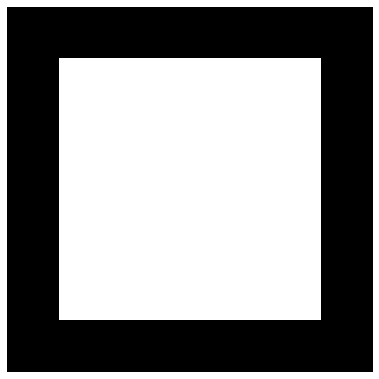

speckle


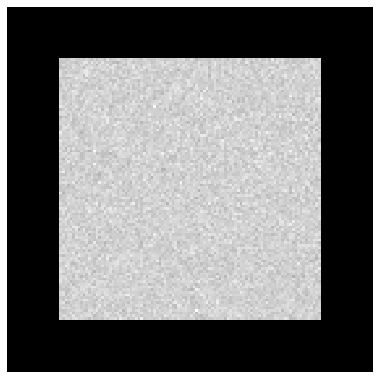

gauss


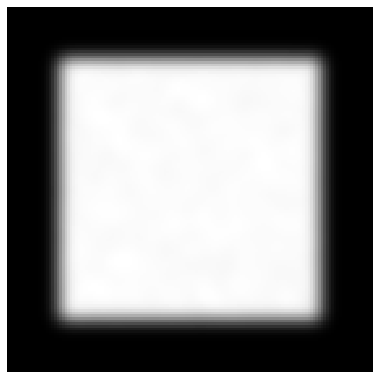

median


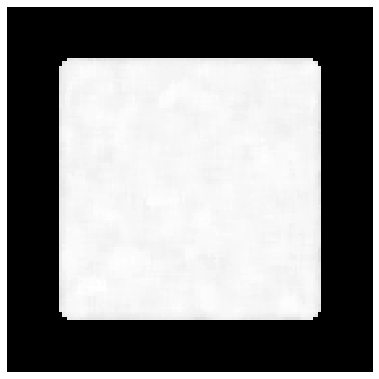

curvatureflow


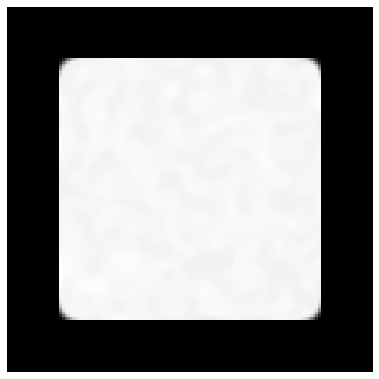

anisotropicdiff


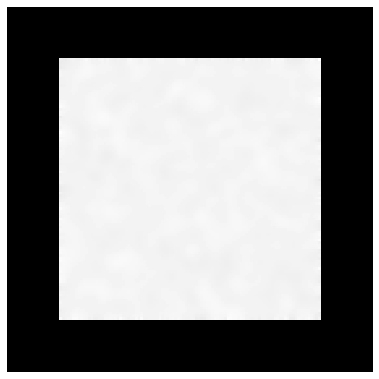

In [8]:
# show and save all the images
for key, image in dict_img.items():
    print(key)
    
    plt.imshow(sitk.GetArrayViewFromImage(image), cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(RESULTS_EXP_PATH + '/' + key + '.png')
    plt.show()

# Statistics

In [9]:
def calc_mse(imgorg, imgfilter):
    """ Calculate the mean squared error. """
    return np.mean((imgorg - imgfilter) ** 2 )

def calc_psnr(imgorg, imgfilter):
    """ Calculate the peak signal-to-noise ratio (PSNR). """
    mse = np.mean( (imgorg - imgfilter) ** 2 )
    # MSE is zero means no noise is present in the signal
    # Therefore, PSNR is 100. 
    if mse == 0:
        return 100
    
    PIXEL_MAX = 255.0   
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse)) 

In [10]:
for key, image in dict_img.items():   
    if not isinstance(image, np.ndarray):
        image = sitk.GetArrayFromImage(image)
        org = sitk.GetArrayFromImage(dict_img['original'])
    
    mse = calc_mse(org, image)
    ssim = calc_ssim(org, image, data_range=image.max() - image.min())
    psnr = calc_psnr(org, image) 
    
    print(key, 'MSE', round(mse,6))
    print(key, 'ssim', round(ssim,3))
    print(key, 'PSNR', round(psnr,3))     
    

original MSE 0.0
original ssim 1.0
original PSNR 100
speckle MSE 0.001289
speckle ssim 0.681
speckle PSNR 77.03
gauss MSE 0.013976
gauss ssim 0.745
gauss PSNR 66.677
median MSE 0.001151
median ssim 0.964
median PSNR 77.521
curvatureflow MSE 0.000932
curvatureflow ssim 0.976
curvatureflow PSNR 78.437
anisotropicdiff MSE 2.8e-05
anisotropicdiff ssim 0.988
anisotropicdiff PSNR 93.644
